In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('/Users/carterhogan/CaseStudies/world_value_survey/analysis/data/wvs/wave7.csv')

/var/folders/k9/j4977wt918z9ns7wk6kqfmqm0000gn/T/ipykernel_55336/3745075923.py:5: DtypeWarning: Columns (349,351) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/carterhogan/CaseStudies/world_value_survey/analysis/data/wvs/wave7.csv')


In [11]:
corruption_questions = [f"Q{i}" for i in range(112, 120)]
baseline_corruption = ["Q112"]
group_corruption = [f"Q{i}" for i in range (113,117)]

na_values = any(df.loc[:, corruption_questions].isna().sum()/len(df) != 0)
print("There are missing values in the corruption data" if na_values else "There are no NA values")
df=df[(df['baseline_corruption']>0) & (df['Q113']>0) & (df['Q114']>0) & (df['Q115']>0) & (df['Q116']>0) & (df['Q117']>0)]


There are no NA values


In [12]:
scaler = MinMaxScaler()
scaler.fit(df.loc[:, group_corruption])
df.loc[:, group_corruption] = scaler.transform(df.loc[:, group_corruption])


scaler.fit(df.loc[:, baseline_corruption])
df.loc[:, baseline_corruption] = scaler.transform(df.loc[:, baseline_corruption])


df['baseline_corruption'] = df['Q112']

df['group_corruption'] = df[['Q113','Q114','Q115','Q116','Q117']].mean(axis=1)


/var/folders/k9/j4977wt918z9ns7wk6kqfmqm0000gn/T/ipykernel_55336/3417546827.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.         1.         0.66666667 ... 0.66666667 0.33333333 0.33333333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, baseline_corruption] = scaler.transform(df.loc[:, baseline_corruption])


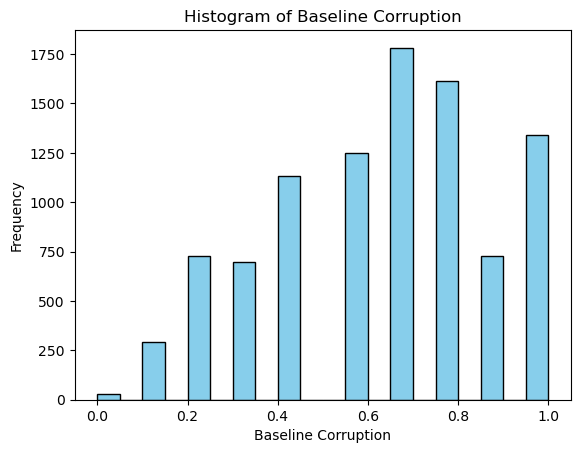

In [14]:
plt.hist(df['baseline_corruption'], bins=20, edgecolor='black', color='skyblue')

# Add labels and title
plt.xlabel('Baseline Corruption')
plt.ylabel('Frequency')
plt.title('Histogram of Baseline Corruption')

# Show the plot
plt.show()

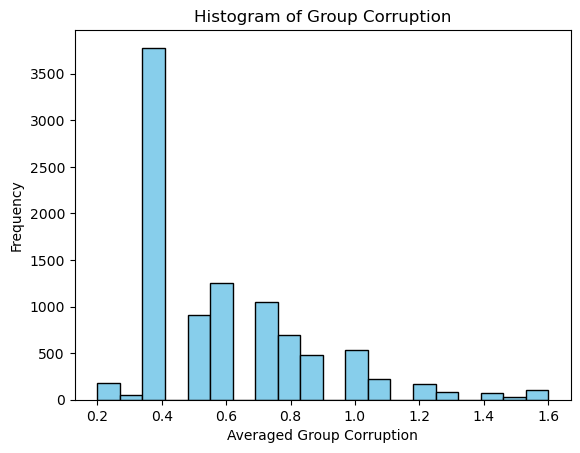

In [15]:
plt.hist(df['group_corruption'], bins=20, edgecolor='black', color='skyblue')

# Add labels and title
plt.xlabel('Averaged Group Corruption')
plt.ylabel('Frequency')
plt.title('Histogram of Group Corruption')

# Show the plot
plt.show()

In [ ]:
# Define attach corruption index
def attach_corruption_index(df: pd.DataFrame) -> pd.DataFrame:
  """
  # Creating a trust index

  Attaches trust indeces for base, national and international trust to the dataframe.
  Furthermore, all trust related questions are preprocessed by imputing with the median and MinMaxScaled.

  Parameters:
    df(pd.DataFrame): the wave7.csv dataframe stored by the data_filter_merge.ipynb
  
  Returns:
    pd.DataFrame: Processed dataframe with the distrust indeces in `base_distrust_index`, `national_distrust_index`, `international_distrust_index`
  """

  baseline_corruption = ["Q112"]
  corruption_questions = [f"Q{i}" for i in range(112, 120)]
  group_corruption  = [f"Q{i}" for i in range(113, 117)]

  result = df.copy()

  # 1. imputing with median --------------------------------------------
  # create a median dict with all the relevant values
  median_dict = {}
  countries = result.B_COUNTRY.unique()

  for ct in countries:
      median_dict[ct] = {}

  for tq in corruption_questions:
      for ct in countries:
          median_dict[ct][tq] = result.loc[(result[tq] > 0) & (result.B_COUNTRY == ct), tq].median()
  
  # now populate the dataframe with the median values
  for tq in corruption_questions:
      result[tq] = result.loc[:, [tq, "B_COUNTRY"]].apply(lambda row: median_dict[row["B_COUNTRY"]][tq] if row[tq] <= 0 else row[tq], axis=1)
    
  # 2. Minmax scaling --------------------------------------------
  scaler = MinMaxScaler()
  scaler.fit(result.loc[:, corruption_questions])
  result.loc[:, corruption_questions] = scaler.transform(result.loc[:, corruption_questions])

  # 3. Creating trust indeces by rowwise mean --------------------------------------------
  result["baseline_corruption"] = result.loc[:, baseline_corruption]
  result["group_corruption"] = result.loc[:, group_corruption].mean(axis=1)


  return result

